In [108]:
import numpy as np
import torch

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from bgan.datasets import SynthDataset, make_semi_dataset, make_batch_generator
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import FactorizedNormalPrior

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
data = SynthDataset(x_dim=2, N=500, num_clusters=3, seed=5, spread=5., labeled=True)
labeled, unlabeled = make_semi_dataset(data, labeled_fraction=0.05)
dataloader_labeled = torch.utils.data.DataLoader(labeled, batch_size=5, shuffle=True)
dataloader_unlabeled = torch.utils.data.DataLoader(unlabeled, batch_size=5, shuffle=True)

In [110]:
np.setdiff1d(np.arange(100), np.random.choice(100, size=10)).shape

(90,)

True labels

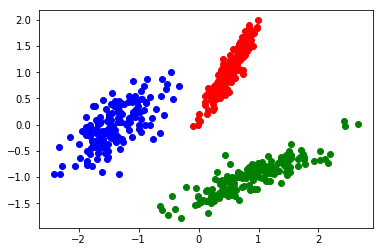

In [111]:
x = data.X.numpy()
y = data.y.numpy()[:, 0]
x_r, x_f = pca(x, x)
plt.plot(x_r[y == 0][:, 0], x_r[y == 0][:, 1], 'bo')
plt.plot(x_r[y == 1][:, 0], x_r[y == 1][:, 1], 'ro')
plt.plot(x_r[y == 2][:, 0], x_r[y == 2][:, 1], 'go')
# plt.plot(x_r[y == 3][:, 0], x_r[y == 3][:, 1], 'mo')

Semi Labels

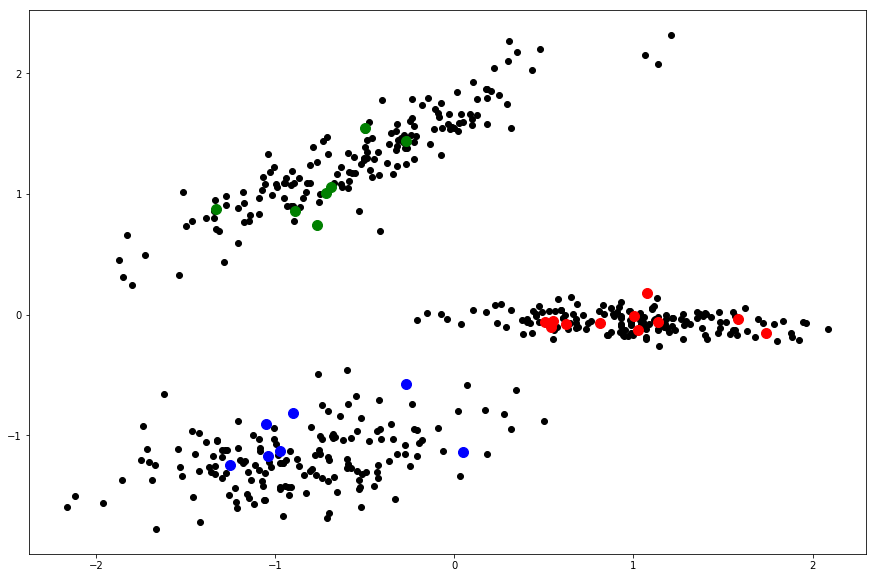

In [112]:
x_labeled = labeled.X.numpy()
y_labeled = labeled.y.numpy()[:, 0]
x_unlabeled = unlabeled.X.numpy()
x_l, x_u = pca(x_labeled, x_unlabeled)

plt.figure(figsize=(15, 10))
plt.plot(x_u[:, 0], x_u[:, 1], 'ko')
plt.plot(x_l[y_labeled == 0][:, 0], x_l[y_labeled == 0][:, 1], 'bo', ms=10)
plt.plot(x_l[y_labeled == 1][:, 0], x_l[y_labeled == 1][:, 1], 'ro', ms=10)
plt.plot(x_l[y_labeled == 2][:, 0], x_l[y_labeled == 2][:, 1], 'go', ms=10)
plt.plot(x_l[y_labeled == 3][:, 0], x_l[y_labeled == 3][:, 1], 'mo', ms=10)

## Supervised

In [113]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, x_dim, K, h_dim):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(x_dim, K, h_dim)
        self.K = K
    
    def build_net(self, x_dim, K, h_dim):
        self.network = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, K),
            nn.Softmax()
        )
    
    def forward(self, input):
        output = self.network(input)
        return output

In [117]:
class SemiClassifier():
    
    def __init__(self, net, lr=0.01):#, unlabeled_ds=None, semi=True, labeled_ds, ):
        self.net = net
        self._init_optimizer(lr)
    
    def loss(self, x_l, y_l, x_u=None):
        
        d_l = self.net.forward(x_l)
            
        ce = nn.NLLLoss()
        l_loss = ce(torch.log(d_l), y_l)
        loss = l_loss
        if x_u is not None:
            d_u = self.net.forward(x_u)
#             max_probs = torch.max(torch.log(d_u), 1)[0]
#             u_loss = torch.mean(-max_probs) / 10
#             loss += u_loss
            loss += -torch.sum(d_u * torch.log(d_u)) / 10
    
        return loss
        
    
    def _init_optimizer(self, lr):
        self.optimizer = optim.Adam(self.net.parameters(),
                lr=lr, betas=(0.5, 0.999))
        
    def step(self, x_l, y_l, x_u=None):
        
        self.net.zero_grad()
        loss = self.loss(x_l, y_l, x_u)   
        loss.backward()
        self.optimizer.step()
        return loss.data.numpy()
        
    def predict(self, x):
        return self.net.forward(x)
    
class GANBasedClassifier():
    
    def __init__(self, net, lr=0.01):#, unlabeled_ds=None, semi=True, labeled_ds, ):
        self.net = net
        self._init_optimizer(lr)
    
    def loss(self, x_l, y_l, x_u=None, z=None):
        
        d_l = self.net.forward(x_l)
            
        ce = nn.NLLLoss()
        l_loss = ce(torch.log(d_l), y_l)
        loss = l_loss
        if x_u is not None:
            d_u = self.net.forward(x_u)
            sum_probs = torch.sum(d_u, 1)[:-1] # Right?
            u_loss = -torch.mean(torch.log(sum_probs))
            loss += u_loss
#             loss += -torch.sum(d_u * torch.log(d_u)) / 10

        if z is not None:
            d_z = self.net.forward(z)
            z_vals = torch.ones(z.size()[0]) * (self.net.K-1)
            z_vals = Variable(z_vals, requires_grad=False).long()
            z_loss = ce(torch.log(d_z), z_vals)
            loss += z_loss
        
        return loss
        
    
    def _init_optimizer(self, lr):
        self.optimizer = optim.Adam(self.net.parameters(),
                lr=lr, betas=(0.5, 0.999))
        
    def step(self, x_l, y_l, x_u=None, z=None):
        
        self.net.zero_grad()
        loss = self.loss(x_l, y_l, x_u, z)   
        loss.backward()
        self.optimizer.step()
        return loss.data.numpy()
        
    def predict(self, x):
        return self.net.forward(x)
    
def make_z_gen(batch_size):
    while True:
        z = 6 * (np.random.rand(batch_size, 2) - 0.5)
        z = torch.from_numpy(z).float()
        yield Variable(z, requires_grad=False)
        
def make_z_gen_from_unlabeled(batch_size, dataset):
    ds_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=2)
    while True:
        for batch in ds_loader:
            z = 1 * (np.random.rand(batch_size, 2) - 0.5)
            z = torch.from_numpy(z).float()
            z = Variable(z, requires_grad=False)
            x = batch
            yield Variable(x, requires_grad=False) + z

In [118]:
net_sup = DiscriminatorNetwork(2, 3, 500)
net_sup.apply(weights_init)
net_semi = DiscriminatorNetwork(2, 3, 100)
net_semi.apply(weights_init)
model_sup = SemiClassifier(net_sup, lr=1e-3)
model_semi = SemiClassifier(net_semi, lr=1e-3)

In [119]:
labeled_gen = make_batch_generator(labeled, 5)
unlabeled_gen = make_batch_generator(unlabeled, 5)

In [43]:
for i in range(1000):
    x_l, y_l = next(labeled_gen)
    x_u = next(unlabeled_gen)
    if not(i % 100) and (i > 0):
        print(i, loss_sup, loss_semi)
    loss_sup = model_sup.step(x_l, y_l)
    loss_semi = model_semi.step(x_l, y_l, x_u)

100 [ 0.27240175] [ 1.35795379]
200 [ 0.09773489] [ 0.77518988]
300 [ 0.03478173] [ 0.23780186]
400 [ 0.02644496] [ 0.14550242]
500 [ 0.008265] [ 0.1259371]
600 [ 0.01258023] [ 0.05118195]
700 [ 0.00108185] [ 0.02763947]
800 [ 0.00200438] [ 0.01022925]
900 [ 0.00507076] [ 0.04719128]


(250000,)
(250000, 3)
0 : 77269
1 : 86926
2 : 85805
[2 2 2 ..., 1 1 1]
77269


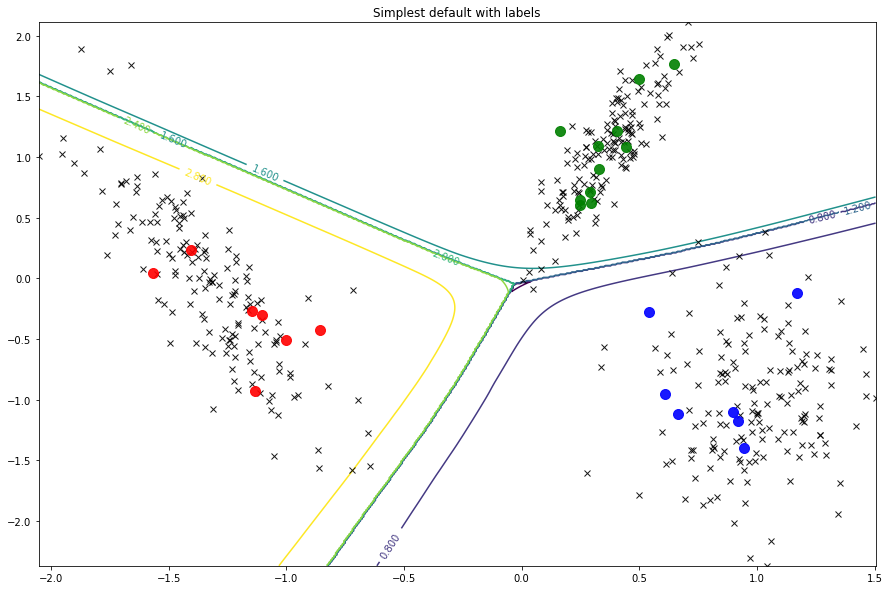

In [44]:
visualize(model_sup, labeled, unlabeled, n_grid=500)

(10000,)
(10000, 3)
0 : 2875
1 : 3160
2 : 3965
[2 2 2 ..., 1 1 1]
2875


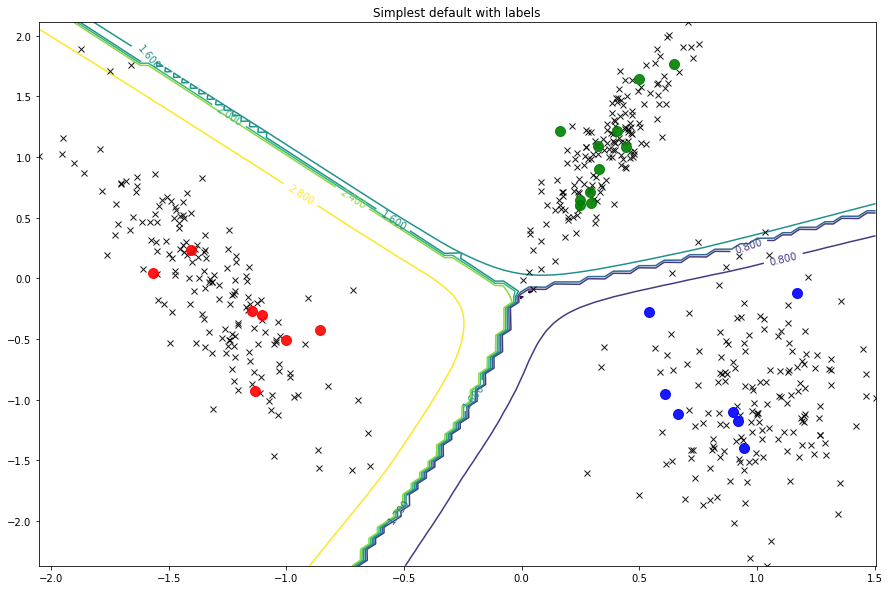

In [45]:
visualize(model_semi, labeled, unlabeled)

In [114]:
def visualize(classifier, labeled_ds, unlabeled_ds, x_min=None, x_max=None, y_min=None, y_max=None, n_grid=100,
             with_last_class=True):
    
    X_l = labeled_ds.X.numpy()
    y_l = labeled_ds.y.numpy().astype(int)[:, 0]
    X_u = unlabeled_ds.X.numpy()
    X = np.vstack([X_l, X_u])
    
    min_ = np.array((np.min(X[:, 0]), np.min(X[:, 1])))
    max_ = np.array((np.max(X[:, 0]), np.max(X[:, 1])))

    if x_max is None: x_max = max_[0]
    if x_min is None: x_min = min_[0]
    if y_max is None: y_max = max_[1]
    if y_min is None: y_min = min_[1]
    
    w_grid_x = np.linspace(x_min, x_max, num=n_grid)
    w_grid_y = np.linspace(y_min, y_max, num=n_grid)
    w_grid_x_, w_grid_y_ = np.meshgrid(w_grid_x, w_grid_y)
    
    w_grid_x_ = w_grid_x_.reshape(-1)[:, None]
    w_grid_y_ = w_grid_y_.reshape(-1)[:, None]
    w_grid = np.hstack([w_grid_x_, w_grid_y_])
    w_grid = Variable(torch.from_numpy(w_grid).float())
    
    probs = classifier.net.forward(w_grid).data.numpy()
    if not with_last_class:
        probs = probs[:, :-1]

    color_lst = ['bo', 'go', 'ro', 'yo', 'mo', 'ko']
    
    plt.figure(figsize=(15, 10))
    plt.title('Simplest default with labels')
    plt.plot(X_u[:, 0], X_u[:, 1], 'kx', alpha=0.9)
    for cl in range(np.max(y_l)+1):
        plt.plot(X_l[y_l == cl][:, 0], X_l[y_l == cl][:, 1], color_lst[cl], alpha=0.9, ms=10)
        
    classes = np.argmax(probs, axis=1)
    print(classes.shape)
    print(probs.shape)
    val = classes + np.max(probs, axis=1)
    for cl in range(np.max(y_l)+1):
        print(cl, ':', np.sum(classes == cl))
    print(classes)
    print(np.sum(classes == 0))
    CS = plt.contour(w_grid_x, w_grid_y, val.reshape((n_grid, n_grid)))
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])

## GAN-like

In [115]:
net_gan = DiscriminatorNetwork(2, 4, 500)
net_gan.apply(weights_init)
model_gan = GANBasedClassifier(net_gan, lr=1e-3)

In [120]:
labeled_gen = make_batch_generator(labeled, 5)
unlabeled_gen = make_batch_generator(unlabeled, 5)
# z_gen = make_z_gen(5)
z_gen = make_z_gen_from_unlabeled(5, unlabeled)

In [124]:
for i in range(1000):
    x_l, y_l = next(labeled_gen)
    x_u = next(unlabeled_gen)
    z = next(z_gen)
    if not(i % 100) and (i > 0):
        print(i, loss)
    loss = model_gan.step(x_l, y_l, x_u, z)

100 [ 1.01346827]
200 [ 1.33465099]
300 [ 0.87510288]
400 [ 0.99771267]
500 [ 1.02560902]
600 [ 1.01842058]
700 [ 1.14598703]
800 [ 1.33360863]
900 [ 1.04397583]


(250000,)
(250000, 3)
0 : 73243
1 : 59348
2 : 117409
[2 2 2 ..., 1 1 1]
73243


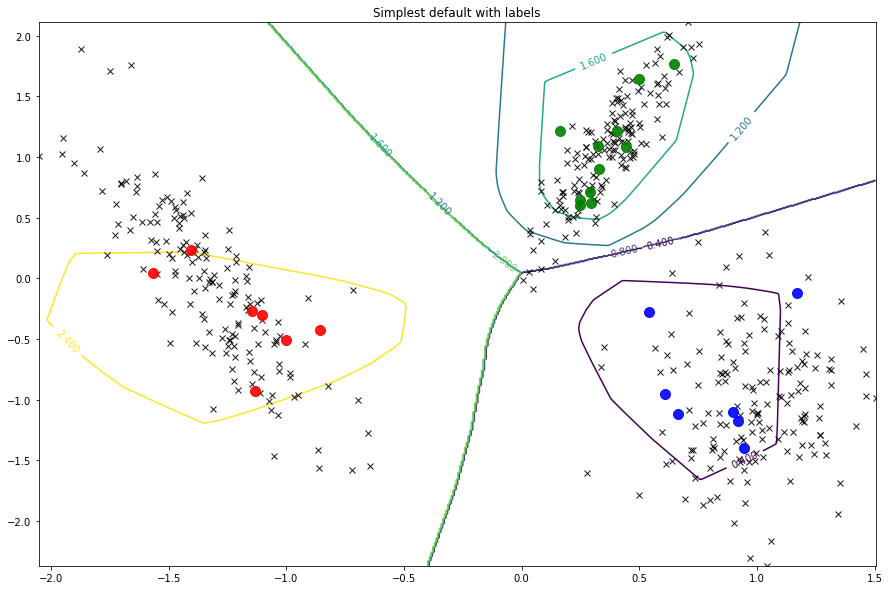

In [125]:
visualize(model_gan, labeled, unlabeled, with_last_class=False, n_grid=500)